## 1. Data preprocessing (lab 1)

### Fetch data

In [103]:
from ucimlrepo import fetch_ucirepo

heart_disease = fetch_ucirepo(id=45)

### Create a feature matrix

In [104]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

cat_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
num_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]

original_df = heart_disease.data.features

# Prepare categorical data
imputer = SimpleImputer(strategy="most_frequent")
original_df.loc[:, cat_features] = imputer.fit_transform(original_df[cat_features])

encoder = OneHotEncoder(categories="auto", sparse_output=False)
encoded_cat_data = encoder.fit_transform(original_df[cat_features])
encoded_features = encoder.get_feature_names_out(cat_features)
original_df[encoded_features] = pd.DataFrame(encoded_cat_data, columns=encoded_features)

# Prepare numerical data
scaler = MinMaxScaler()
scaled_num_data = scaler.fit_transform(original_df[num_features])
original_df[num_features] = pd.DataFrame(scaled_num_data, columns=num_features)

# Convert DataFrame to feature matrix
original_df = original_df.drop(columns=cat_features)
# print(original_df.columns)
X = original_df.to_numpy()

### Create a target vector (convert values to {0,1} for binary classification)

In [105]:
import numpy as np

y = heart_disease.data.targets.to_numpy()
y_binary = np.where(y >= 1, 1, 0)

### Verify matrix/vector dimensions

In [106]:
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y_binary.shape}")

Feature matrix shape: (303, 28)
Target vector shape: (303, 1)


### Split dataset to test and train subsets

In [107]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [108]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (242, 28)
X_test shape: (61, 28)
y_train shape: (242, 1)
y_test shape: (61, 1)


## 2. Model

### Hiperparameters

In [109]:
ALPHA = 0.0001 # Doesnt work for 0.0001
ITER_LIMIT = 250
EPSILON = 0.0001
TRESHOLD = 0.5

### Functions

- $\sigma(x) = \frac{1}{1 + e^{-x}}$  
- $sigmoid(X=[x_{1}, x_{2}, ..., x_{n}]) = [\sigma(x_{1}), \sigma(x_{2}), ..., \sigma(x_{n})]$  

##### Let:  
$X_{i \times j}$=
$\begin{bmatrix}
    x_{11} & x_{12} & x_{13} & \dots  & x_{1j} \\
    x_{21} & x_{22} & x_{23} & \dots  & x_{2j} \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{i1} & x_{i2} & x_{i3} & \dots  & x_{ij}
\end{bmatrix}$, 
$W_{1 \times j}$=
$\begin{bmatrix}
    w_{1} & w_{2} & w_{3} & \dots  & w_{j}
\end{bmatrix}$,
$b_{1 \times 1}$=
$\begin{bmatrix}
    bias
\end{bmatrix}$,  

##### Then:
- $pred\_prob(X_{i \times j}, W_{1 \times j}, b_{1 \times 1}) = sigmoid(((XW^{T})_{i \times 1} + b\_ext_{i \times 1})_{i \times 1})$  
- $update\_weights(X_{i \times j}, W_{1 \times j}, p_{i \times 1}, y_{i \times 1}) = W_{1 \times j} + \alpha * (((y_{i \times 1} - p_{i \times 1})^{T})_{1 \times i}X_{i \times j})_{1 \times j}$

In [110]:
def sigmoid(vector: np.array) -> np.array:
    return 1 / (1 + np.exp(-vector))


def pred_prob(X: np.array, W: np.array, b: np.array) -> np.array:
    vector = (X @ W) + b
    return sigmoid(vector)


def update_weights(X: np.array, W: np.array, p: np.array, y: np.array) -> np.array:
    gradient = (y-p).T @ X
    # gradient = np.dot((y - p).T, X)
    return (W + (ALPHA * gradient).T)


def update_bias(b: np.array, p: np.array, y: np.array) -> np.array:
    gradient = np.sum(y - p)
    return b + (ALPHA * gradient)

### Model training

In [111]:
from sklearn.metrics import accuracy_score, f1_score, recall_score


def run(epoch_limit: int) -> dict[int, dict[str, np.float64]]:
    results = {}

    input_size = X_train.shape[1]
    W = (np.random.randn(input_size, 1) * 0.01)
    b = np.zeros((1,1))

    for i in range(epoch_limit):
        p = pred_prob(X_train, W, b)
        W_updated = update_weights(X_train, W, p, y_train)
        # b = update_weights(X=np.ones((1,1)), W=b, p=p, y=y_train)
        b = update_bias(b, p, y_train)
        test_p = pred_prob(X_test, W, b)
        test_p_binary = (test_p >= TRESHOLD).astype(int)
        results[i] = {
            "recall": recall_score(y_true=y_test, y_pred=test_p_binary),
            "f1": f1_score(y_true=y_test, y_pred=test_p_binary),
            "accuracy": accuracy_score(y_true=y_test, y_pred=test_p_binary)
        }
        if (np.abs(W_updated - W) <= EPSILON).all():
            return results
        W = W_updated
    return results

In [115]:
results = run(150)

In [113]:
import matplotlib.pyplot as plt


def plot_results(results: dict[int, np.float64]):
    x = list(results.keys())
    recall = [results[i]['recall'] for i in x]
    f1 = [results[i]['f1'] for i in x]
    accuracy = [results[i]['accuracy'] for i in x]

    plt.figure(figsize=(8, 6))
    plt.plot(x, recall, linestyle='-', color='r', label='Recall')
    plt.plot(x, f1, linestyle='-', color='g', label='F1 Score')
    plt.plot(x, accuracy, linestyle='-', color='b', label='Accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Recall score')
    plt.title('Plot of recall scores')

    plt.xlim(0, 150)

    plt.legend()

    plt.grid(True)
    plt.show()

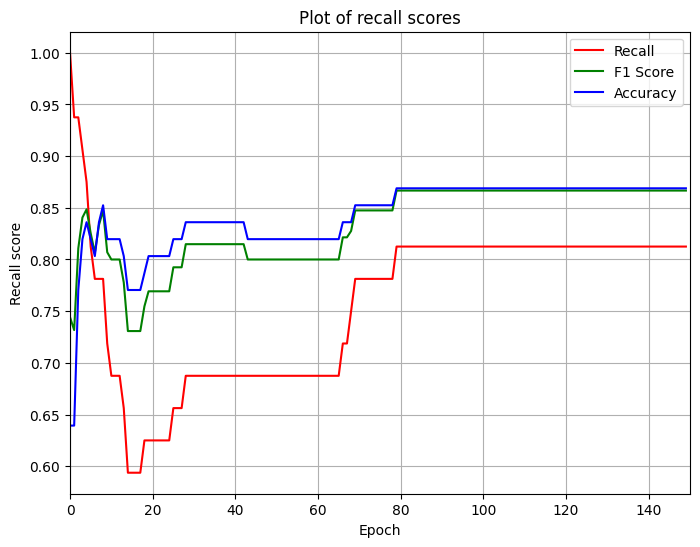

In [116]:
plot_results(results)